# Cross Section for Many Lines using PreMODIT

Update: October 30/2022, Hajime Kawahara

We demonstarte the Precomputation of opacity version of Modified Discrete Integral Transform (PreMODIT), which is the modified version of MODIT for exojax. PreMODIT uses the evenly-spaced logarithm grid (ESLOG) as a wavenumber dimension. PreMODIT takes advantage especially for the case that the number of the molecular line is large (typically > 100,000). We here compare the results by PreMODIT with the direct computation (LPF).

Here, we use FP64, but if you want you can use FP32 (but slightly large errors):

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import matplotlib.pyplot as plt
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import api
from exojax.utils.grids import wavenumber_grid

# Setting wavenumber bins and loading HITRAN database
nus, wav, R = wavenumber_grid(1900.0,
                              2300.0,
                              350000,
                              unit="cm-1",
                              xsmode="premodit")
mdbCO = api.MdbHitran('CO', nus)

# set T, P and partition function
Mmol = 28.01  # molecular weight
Tfix = 1000.0  # we assume T=1000K
Pfix = 1.e-3  # we compute P=1.e-3 bar
Ppart = Pfix  #partial pressure of CO. here we assume a 100% CO atmosphere.


xsmode assumes ESLOG in wavenumber space: mode=premodit
Background atmosphere:  H2
Error: Couldn't download .def file at http://www.exomol.com/db///CO/__CO.def and save.
Error: Couldn't download .pf file at http://www.exomol.com/db///CO/__CO.pf and save.
Error: Couldn't download .states.bz2 file at http://www.exomol.com/db///CO/__CO.states.bz2 and save.
Error: Couldn't download .broad file at http://www.exomol.com/db///__H2.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db///__He.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db///__air.broad and save.


FileNotFoundError: [Errno 2] No such file or directory: 'CO/__CO.def'

In [3]:
qt=mdbCO.qr_interp(0,Tfix) #isotope=0

#computes logsij0 etc in device
mdbCO.generate_jnp_arrays()
# compute Sij, gamma_L, sigmaD
Sij=SijT(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)
gammaL = gamma_hitran(Pfix,Tfix, Ppart, mdbCO.n_air, \
                      mdbCO.gamma_air, mdbCO.gamma_self) \
+ gamma_natural(mdbCO.A)

MODIT uses the normalized quantities by wavenumber/R, where R is the spectral resolution. In this case, the normalized Doppler width (nsigmaD) is common for the same isotope. Then, we use a 2D DIT grid with the normalized gammaL and q = R log(nu).

In [4]:
from exojax.spec.hitran import normalized_doppler_sigma
dv_lines=mdbCO.nu_lines/R
nsigmaD=normalized_doppler_sigma(Tfix,Mmol,R)
ngammaL=gammaL/dv_lines

MODIT uses a grid of ngammaL, and wavenumber. set_ditgrid.ditgrid_log_interval makes a 1D grid (evenly log spaced) for ngamma.

In [5]:
from exojax.spec.set_ditgrid import ditgrid_log_interval

ngammaL_grid = ditgrid_log_interval(ngammaL)


Text(0, 0.5, 'normalized gammaL')

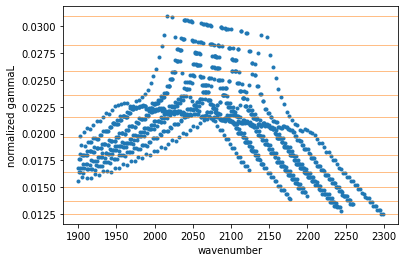

In [6]:
#show the grids
plt.plot(mdbCO.nu_lines, ngammaL, ".")
for i in ngammaL_grid:
    plt.axhline(i, lw=1, alpha=0.5, color="C1")
plt.xlabel("wavenumber")
plt.ylabel("normalized gammaL")

We need to precompute the contribution for wavenumber and pmarray. These can be computed using init_dit. 

In [7]:
from exojax.spec import initspec

cnu, indexnu, R, pmarray = initspec.init_modit(mdbCO.nu_lines, nus)


Let's compute the cross section!

In [8]:
from exojax.spec.modit import xsvector
xs=xsvector(cnu,indexnu,R,pmarray,nsigmaD,ngammaL,Sij,nus,ngammaL_grid)

Also, we here try the direct computation using LPF for the comparison purpose

In [9]:
from exojax.spec import xsection
sigmaD=doppler_sigma(mdbCO.nu_lines,Tfix,Mmol)
xsv=xsection(nus,mdbCO.nu_lines,sigmaD,gammaL,Sij,memory_size=30)

100%|██████████| 56/56 [00:08<00:00,  6.36it/s]


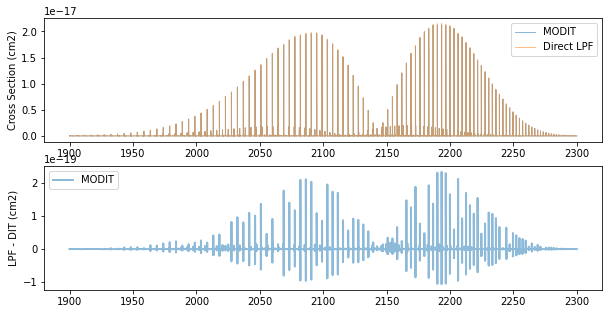

In [10]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,xs,lw=1,alpha=0.5,label="MODIT")
plt.plot(nus,xsv,lw=1,alpha=0.5,label="Direct LPF")
plt.legend(loc="upper right")
plt.ylabel("Cross Section (cm2)")
ax=fig.add_subplot(212)
plt.plot(nus,xsv-xs,lw=2,alpha=0.5,label="MODIT")
plt.ylabel("LPF - DIT (cm2)")
plt.legend(loc="upper left")
plt.show()

There is about 1 % deviation between LPF and MODIT. 

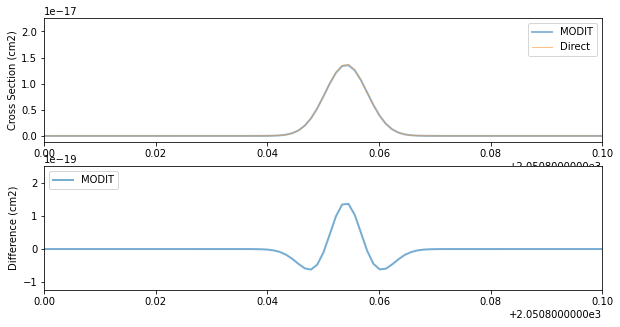

In [11]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,xs,lw=2,alpha=0.5,label="MODIT")
plt.plot(nus,xsv,lw=1,alpha=0.5,label="Direct")
plt.legend(loc="upper right")
plt.xlim(2050.8,2050.9)
plt.ylabel("Cross Section (cm2)")
ax=fig.add_subplot(212)
plt.plot(nus,xsv-xs,lw=2,alpha=0.6,label="MODIT")
plt.legend(loc="upper left")
plt.ylabel("Difference (cm2)")
plt.xlim(2050.8,2050.9)
#plt.yscale("log")
plt.savefig("fine_grid.png")